# Question1

For a binary classification problem where the final layer has one neuron and the output activation is chosen to be appropriate for binary classification, the standard and most robust choice is Binary Cross-Entropy Loss with Logits.
The model description states:


 1-Final layer: nn.Linear with 1 neuron.


 2-Output layer activation: "use the appropriate activation for the binary classification case."


 (This typically implies $\text{sigmoid}$ activation if the loss function is $\text{nn.BCELoss}()$, or no explicit activation if the loss function is $\text{nn.BCEWithLogitsLoss}()$).
$\text{nn.BCEWithLogitsLoss}()$ is preferred because it combines the $\text{sigmoid}$ activation and the binary cross-entropy loss into one stable numerical operation. It takes the raw logits (output of the final linear layer) as input, which is the most common practice in PyTorch for binary classification.
The $\text{nn.BCEWithLogitsLoss}()$ formula is:$$\text{Loss} = - \frac{1}{N} \sum_{i=1}^{N} [y_i \log(\sigma(x_i)) + (1 - y_i) \log(1 - \sigma(x_i))]$$
where $x_i$ are the logits (raw outputs) and $\sigma$ is the sigmoid function.




Answer: $\text{nn.BCEWithLogitsLoss}()$

# Setup and Reproducibility

In [2]:
!wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip


--2025-12-02 21:25:26--  https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/405934815/e712cf72-f851-44e0-9c05-e711624af985?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-02T22%3A15%3A04Z&rscd=attachment%3B+filename%3Ddata.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-02T21%3A14%3A12Z&ske=2025-12-02T22%3A15%3A04Z&sks=b&skv=2018-11-09&sig=Psj1ft1a9o5jQw1SIOB9bwzd46GpORCxuCUQ%2F1yId1k%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NDcxMjUyNiwibmJmIjoxNzY0NzEwNzI2LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5i

In [4]:
!unzip data.zip


Archive:  data.zip
   creating: data/
   creating: data/test/
   creating: data/test/curly/
  inflating: data/test/curly/03312ac556a7d003f7570657f80392c34.jpg  
  inflating: data/test/curly/106dfcf4abe76990b585b2fc2e3c9f884.jpg  
  inflating: data/test/curly/1a9dbe23a0d95f1c292625960e4509184.jpg  
  inflating: data/test/curly/341ea26e6677b655f8447af56073204a4.jpg  
  inflating: data/test/curly/61aPFVrm42L._SL1352_.jpg  
  inflating: data/test/curly/6d8acb0fe980774ea4e5631198587f45.png  
  inflating: data/test/curly/7f5649a0c33a2b334f23221a52c16b9b.jpg  
  inflating: data/test/curly/90146673.jpg  
  inflating: data/test/curly/9b3608e01d78fbabc9fb0719323d507f4.jpg  
  inflating: data/test/curly/b171c99161f3cffc12d4b74488ef2fc6.jpg  
  inflating: data/test/curly/blogger_one.jpg  
  inflating: data/test/curly/c03ca1590aa4df74e922ad8257305a2b.jpg  
  inflating: data/test/curly/c1b89bb4f86a3478ec20ce1f63f003c1.jpg  
  inflating: data/test/curly/c5.jpg  
  inflating: data/test/curly/C86_76156

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import os
import matplotlib.pyplot as plt

In [11]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [12]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define directories and parameters
TRAIN_DIR = 'data/train'
TEST_DIR = 'data/test'
BATCH_SIZE = 20
NUM_EPOCHS = 10

Using device: cpu


# Model Definition



In [13]:
class HairTypeClassifier(nn.Module):
    def __init__(self):
        super(HairTypeClassifier, self).__init__()
        # 1. Convolutional Layer
        self.conv_layer = nn.Conv2d(
            in_channels=3,
            out_channels=32,
            kernel_size=(3, 3),
            padding=0,
            stride=1
        )
        # 2. Max Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))

        # Calculate the size after Conv and Pool to set up the Linear layer
        # Input (3, 200, 200) -> Conv (32, 198, 198) -> Pool (32, 99, 99)
        FLATTEN_SIZE = 32 * 99 * 99  # 313632

        # 3. Fully Connected (Linear) Layers
        self.fc1 = nn.Linear(FLATTEN_SIZE, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # Conv + ReLU
        x = torch.relu(self.conv_layer(x))
        # Max Pooling
        x = self.pool(x)
        # Flatten
        x = x.view(x.size(0), -1)
        # Linear 1 + ReLU
        x = torch.relu(self.fc1(x))
        # Linear 2 (Output Logits)
        # We use BCEWithLogitsLoss, so no sigmoid is applied here
        x = self.fc2(x)
        return x

# Initialize Model
model = HairTypeClassifier().to(device)

# --- Check Total Parameters (For Q2) ---
from torchsummary import summary
# summary(model, input_size=(3, 200, 200)) # Can be run if torchsummary is installed
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Model Parameters (Q2): {total_params}")

# --- Define Loss and Optimizer (Q1) ---
# Q1: Loss function for binary classification (log-space is preferred)
criterion = nn.BCEWithLogitsLoss()
# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.8)

Total Model Parameters (Q2): 20073473


# Data Loaders (Questions 3 & 4)

In [14]:
# --- Basic Transformations for Q3 & Q4 ---
train_transforms_basic = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ) # ImageNet normalization
])

# Use the same basic transforms for the test set
test_transforms_basic = train_transforms_basic

# Load datasets
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms_basic)
validation_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transforms_basic)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Training Run 1 (Questions 3 & 4)

In [15]:
print("\n--- Starting Training Run 1 (Q3 & Q4: No Augmentation) ---")

history_no_aug = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(NUM_EPOCHS):
    # --- Training Loop ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # Ensure labels are float and have shape (batch_size, 1) for BCEWithLogitsLoss
        labels = labels.float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # Calculate accuracy: apply sigmoid to logits and threshold at 0.5
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history_no_aug['loss'].append(epoch_loss)
    history_no_aug['acc'].append(epoch_acc)

    # --- Validation Loop ---
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = correct_val / total_val
    history_no_aug['val_loss'].append(val_epoch_loss)
    history_no_aug['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

# --- Analysis for Q3 and Q4 ---
# Q3: Median Training Accuracy
median_train_acc = np.median(history_no_aug['acc'])
print(f"\nQ3 Result (Median Train Acc): {median_train_acc:.4f}")

# Q4: Standard Deviation of Training Loss
std_train_loss = np.std(history_no_aug['loss'])
print(f"Q4 Result (Std Dev Train Loss): {std_train_loss:.4f}")


--- Starting Training Run 1 (Q3 & Q4: No Augmentation) ---
Epoch 1/10, Loss: 0.6462, Acc: 0.6362, Val Loss: 0.6032, Val Acc: 0.6517
Epoch 2/10, Loss: 0.5475, Acc: 0.7100, Val Loss: 0.7251, Val Acc: 0.6318
Epoch 3/10, Loss: 0.5533, Acc: 0.7250, Val Loss: 0.5991, Val Acc: 0.6716
Epoch 4/10, Loss: 0.4802, Acc: 0.7712, Val Loss: 0.6033, Val Acc: 0.6567
Epoch 5/10, Loss: 0.4334, Acc: 0.8025, Val Loss: 0.6196, Val Acc: 0.6766
Epoch 6/10, Loss: 0.3740, Acc: 0.8325, Val Loss: 0.7371, Val Acc: 0.6766
Epoch 7/10, Loss: 0.2721, Acc: 0.8838, Val Loss: 0.9223, Val Acc: 0.6418
Epoch 8/10, Loss: 0.2478, Acc: 0.9000, Val Loss: 0.7294, Val Acc: 0.7214
Epoch 9/10, Loss: 0.2075, Acc: 0.9200, Val Loss: 0.7523, Val Acc: 0.7015
Epoch 10/10, Loss: 0.1494, Acc: 0.9450, Val Loss: 0.7893, Val Acc: 0.7015

Q3 Result (Median Train Acc): 0.8175
Q4 Result (Std Dev Train Loss): 0.1590


In [20]:
# Print the history dictionaries after your training runs
print("HISTORY_NO_AUG_DATA = {")
for key, value in history_no_aug.items():
    # Convert lists of floats to a readable string format
    print(f"    '{key}': {value},")
print("}")



HISTORY_NO_AUG_DATA = {
    'acc': [0.63625, 0.71, 0.725, 0.77125, 0.8025, 0.8325, 0.88375, 0.9, 0.92, 0.945],
    'loss': [0.6462258949875832, 0.547510139644146, 0.5532774537801742, 0.4802091151475906, 0.4333878390491009, 0.374002392962575, 0.27212329134345054, 0.247810354270041, 0.20747391935437917, 0.14940188731998205],
    'val_acc': [0.6517412935323383, 0.6318407960199005, 0.6716417910447762, 0.6567164179104478, 0.6766169154228856, 0.6766169154228856, 0.6417910447761194, 0.7213930348258707, 0.7014925373134329, 0.7014925373134329],
    'val_loss': [0.6032439594838157, 0.7250668498043397, 0.5990864308319281, 0.6032694945881023, 0.6196025607004687, 0.7371423721906558, 0.9222679344279257, 0.729401338456282, 0.7522510044017241, 0.7893380739202547],
}


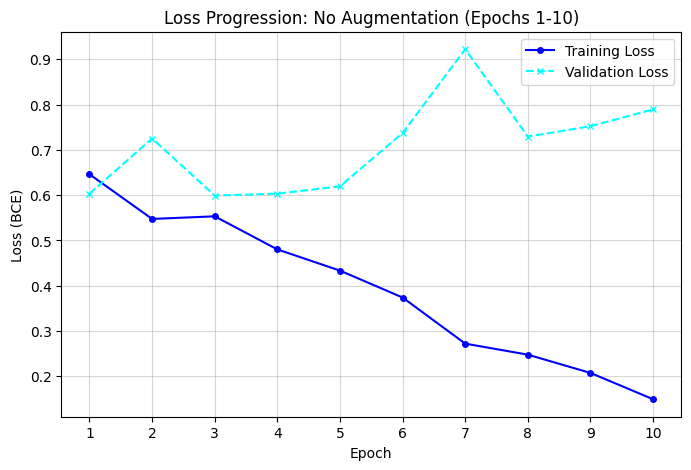

In [22]:
EPOCHS = range(1, 11)

plt.figure(figsize=(8, 5))
plt.plot(EPOCHS, history_no_aug['loss'], label='Training Loss', color='blue', marker='o', markersize=4)
plt.plot(EPOCHS, history_no_aug['val_loss'], label='Validation Loss', color='cyan', linestyle='--', marker='x', markersize=4)
plt.title('Loss Progression: No Augmentation (Epochs 1-10)')
plt.xlabel('Epoch')
plt.ylabel('Loss (BCE)')
plt.xticks(EPOCHS)
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

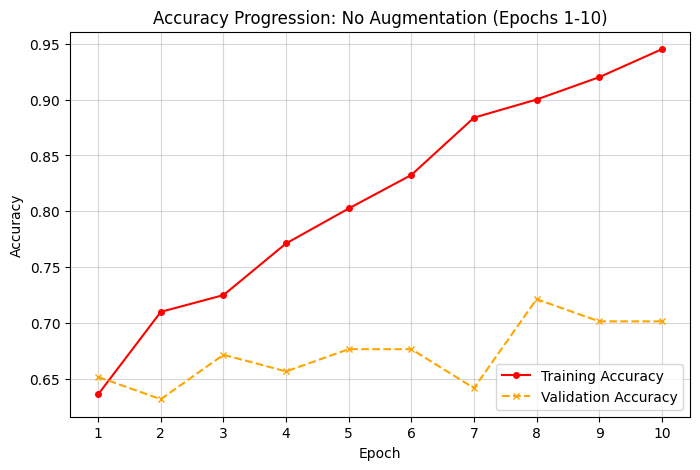

In [23]:
EPOCHS = range(1, 11)

plt.figure(figsize=(8, 5))
plt.plot(EPOCHS, history_no_aug['acc'], label='Training Accuracy', color='red', marker='o', markersize=4)
plt.plot(EPOCHS, history_no_aug['val_acc'], label='Validation Accuracy', color='orange', linestyle='--', marker='x', markersize=4)
plt.title('Accuracy Progression: No Augmentation (Epochs 1-10)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(EPOCHS)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.5)
plt.show()

# Data Loaders (Questions 5 & 6)

In [24]:
# --- Augmentation Transformations for Q5 & Q6 ---
train_transforms_aug = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Re-load training dataset with augmentations
train_dataset_aug = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms_aug)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=BATCH_SIZE, shuffle=True)

# Validation loader remains the same (validation_loader)

# Note: The 'model' and 'optimizer' objects are NOT re-initialized.
# They continue from the state at the end of Run 1.

# Training Run 2 (Questions 5 & 6)

In [25]:
print("\n--- Starting Training Run 2 (Q5 & Q6: With Augmentation) ---")

history_aug = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(NUM_EPOCHS):
    # --- Training Loop (using augmented loader) ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader_aug: # Use augmented loader
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset_aug)
    epoch_acc = correct_train / total_train
    history_aug['loss'].append(epoch_loss)
    history_aug['acc'].append(epoch_acc)

    # --- Validation Loop (using original validation loader) ---
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = correct_val / total_val
    history_aug['val_loss'].append(val_epoch_loss)
    history_aug['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

# --- Analysis for Q5 and Q6 ---
# Q5: Mean Test Loss for all 10 epochs
mean_test_loss = np.mean(history_aug['val_loss'])
print(f"\nQ5 Result (Mean Test Loss with Augmentation): {mean_test_loss:.4f}")

# Q6: Average Test Accuracy for the last 5 epochs (epochs 6 to 10)
last_5_val_acc = history_aug['val_acc'][5:10]
avg_last_5_val_acc = np.mean(last_5_val_acc)
print(f"Q6 Result (Avg Test Acc last 5 epochs with Augmentation): {avg_last_5_val_acc:.4f}")


--- Starting Training Run 2 (Q5 & Q6: With Augmentation) ---
Epoch 1/10, Loss: 0.7357, Acc: 0.5975, Val Loss: 0.6002, Val Acc: 0.6567
Epoch 2/10, Loss: 0.5931, Acc: 0.6325, Val Loss: 0.5687, Val Acc: 0.7214
Epoch 3/10, Loss: 0.5792, Acc: 0.6625, Val Loss: 0.5465, Val Acc: 0.7413
Epoch 4/10, Loss: 0.5649, Acc: 0.7100, Val Loss: 0.6487, Val Acc: 0.6716
Epoch 5/10, Loss: 0.5129, Acc: 0.7175, Val Loss: 0.5755, Val Acc: 0.7114
Epoch 6/10, Loss: 0.5122, Acc: 0.7288, Val Loss: 0.5760, Val Acc: 0.7264
Epoch 7/10, Loss: 0.5108, Acc: 0.7225, Val Loss: 0.4963, Val Acc: 0.7562
Epoch 8/10, Loss: 0.5151, Acc: 0.7412, Val Loss: 0.5081, Val Acc: 0.7413
Epoch 9/10, Loss: 0.5170, Acc: 0.7288, Val Loss: 0.5424, Val Acc: 0.7264
Epoch 10/10, Loss: 0.4989, Acc: 0.7412, Val Loss: 0.5120, Val Acc: 0.7562

Q5 Result (Mean Test Loss with Augmentation): 0.5575
Q6 Result (Avg Test Acc last 5 epochs with Augmentation): 0.7413


In [26]:
print("\nHISTORY_AUG_DATA = {")
for key, value in history_aug.items():
    print(f"    '{key}': {value},")
print("}")


HISTORY_AUG_DATA = {
    'acc': [0.5975, 0.6325, 0.6625, 0.71, 0.7175, 0.72875, 0.7225, 0.74125, 0.72875, 0.74125],
    'loss': [0.7357321716845036, 0.5930864945054054, 0.579167303442955, 0.5648614078760147, 0.5129258364439011, 0.5121742345392704, 0.5107750691473484, 0.5150680311024189, 0.5169998351484537, 0.4988811530172825],
    'val_acc': [0.6567164179104478, 0.7213930348258707, 0.7412935323383084, 0.6716417910447762, 0.7114427860696517, 0.7263681592039801, 0.7562189054726368, 0.7412935323383084, 0.7263681592039801, 0.7562189054726368],
    'val_loss': [0.6001994752913565, 0.568659203859111, 0.5465382521425314, 0.6486706463851739, 0.5755431127192369, 0.5760448720324692, 0.4962878873692223, 0.5081152444455161, 0.5424001311781395, 0.512041651490909],
}


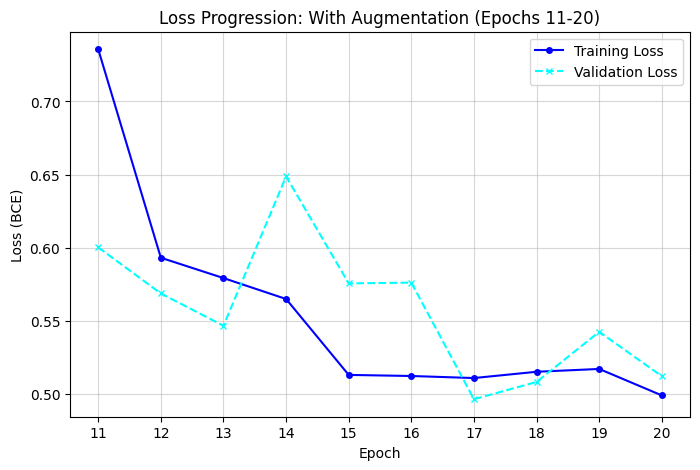

In [27]:
# Epochs 11 through 20 for the continued run
EPOCHS_2 = range(11, 21)

plt.figure(figsize=(8, 5))
plt.plot(EPOCHS_2, history_aug['loss'], label='Training Loss', color='blue', marker='o', markersize=4)
plt.plot(EPOCHS_2, history_aug['val_loss'], label='Validation Loss', color='cyan', linestyle='--', marker='x', markersize=4)
plt.title('Loss Progression: With Augmentation (Epochs 11-20)')
plt.xlabel('Epoch')
plt.ylabel('Loss (BCE)')
plt.xticks(EPOCHS_2)
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

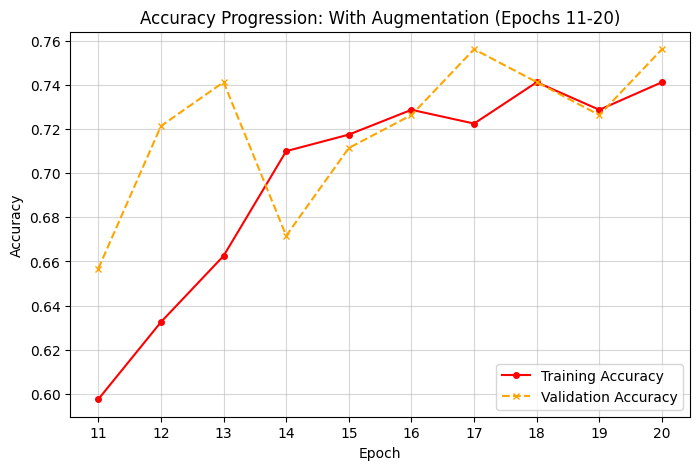

In [28]:
# Epochs 11 through 20 for the continued run
EPOCHS_2 = range(11, 21)

plt.figure(figsize=(8, 5))
plt.plot(EPOCHS_2, history_aug['acc'], label='Training Accuracy', color='red', marker='o', markersize=4)
plt.plot(EPOCHS_2, history_aug['val_acc'], label='Validation Accuracy', color='orange', linestyle='--', marker='x', markersize=4)
plt.title('Accuracy Progression: With Augmentation (Epochs 11-20)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(EPOCHS_2)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.5)
plt.show()